<a href="https://colab.research.google.com/github/minghsu0107/ML/blob/master/boston_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.datasets import boston_housing
(train_data, train_targets),(
    test_data, test_targets)=boston_housing.load_data()

Using TensorFlow backend.


57344/57026 [==============================] - 0s 3us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [0]:
mean = train_data.mean(axis=0)  #沿著第 0 軸 (batch_size 軸) 做平均
train_data -= mean
std = train_data.std(axis=0)  #沿著第 0 軸 (batch_size 軸) 算標準差
train_data /= std

test_data -= mean
test_data /= std

In [0]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()  #建構一個 sequential 模型
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [7]:
import numpy as np

k = 4  #進行 4 折交叉驗證
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)  #準備驗證資料：資料來自 #k 區塊
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    #準備訓練資料：資料來自 #k 以外的所有區塊
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model() #建構 Keras 模型(已編譯)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0) #訓練該模型 (在 silent 靜音模式下, verbose = 0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)  #以驗證資料來評估模型
    all_scores.append(val_mae)

W0717 08:06:41.661547 139953762457472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 08:06:41.690135 139953762457472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 08:06:41.693287 139953762457472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0717 08:06:41.744168 139953762457472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



processing fold # 0


W0717 08:06:41.928229 139953762457472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0717 08:06:41.939050 139953762457472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



processing fold # 1
processing fold # 2
processing fold # 3


In [9]:
print(all_scores)
print(np.mean(all_scores))  #驗證分數的平均值

[2.0581326413862775, 2.2001309324019025, 2.8750618802438868, 2.410775157484678]
2.386025152879186


In [10]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [0]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories])for i in range(num_epochs)]

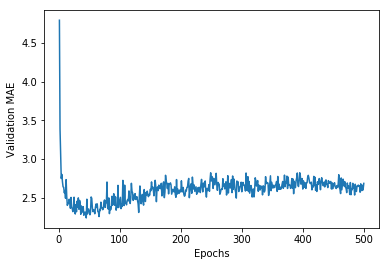

In [12]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history)+ 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

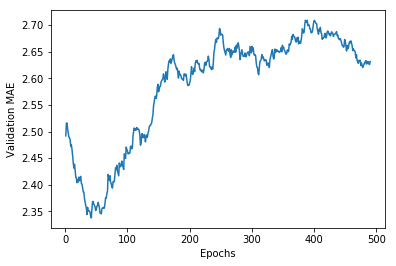

In [13]:
def smooth_curve(points, factor=0.9):  #指數值為 0.9
    smoothed_points = []
    for point in points:
        if smoothed_points:  #運用指數平均數
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point *(1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+ 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [48]:
from keras import optimizers
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer=optimizers.RMSprop(lr=0.00186), loss='mse', metrics=['mae'])
    return model
  
model = build_model()  #建立一個用最佳參數 compile 過的新模型
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)  #以整個資料進行訓練

print(test_mae_score)

102/102 [==============================] - 1s 6ms/step
2.3125309196172976
